# Set-Up

Installations and imports:

In [1]:
fenics_dir = '/root/shared/fenics_models'
# !pip install seaborn matplotlib
import os
from math import ceil
import time
import json
import numpy as np
import sys
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
sys.path.insert(0, fenics_dir)
import fenics_helpers

Plotting settings:

In [2]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
mpl.rcParams['figure.dpi'] = 100
mpl_save_dpi = 300

Save settings:

In [3]:
fig_save_dir = os.path.join(fenics_dir, 'figs')
if not os.path.isdir(fig_save_dir):
    os.mkdir(fig_save_dir)
data_save_dir = os.path.join(fenics_dir, 'data')
if not os.path.isdir(data_save_dir):
    os.mkdir(data_save_dir)

Define parameters which never change between simulations:

In [74]:
always_fixed_params = {# Physical parameters:
                       'density': 0.00102, # in g/mm^3
                       'g': 9.81, # in m/s^3
                       # Beam mesh/geometry parameters:
                       'width': 40, # in mm
                       'length': 90, # in mm
                       'elem_order': 2,
                       # Non-linear solver parameters:
                       'num_load_steps': 30, 
                       'rtol': 1e-9, 
                       'atol': 1e-9, 
                       'max_iter': 50}                         

# Convergence Studies

## Mesh Size Convergence

Informal parameter search shows that greatest displacements occur at around 120 degrees - perform convergence study here.

In [75]:
fixed_params = {'C_1': 1.9, # in kPa
                'beam_angle': 90, # in degrees
                'kappa': 3000, # in kPa
                **always_fixed_params}

# Vary number of elements along width of beam:
NW_list = [1, 2, 3, 4, 5, 6, 7, 8]
  
results = {key: [] for key in ('end_disp', 'elem_size', 'num_elem', 'NW', 'NL', 'volume')}
for i, NW in enumerate(NW_list):
    
    # Compute vertex length of cube elements:
    elem_size = fixed_params['width']/NW
    # Compute number of elements along length of beam:
    NL = ceil(fixed_params['length']/elem_size)

    print(f"Simulating Mesh {i+1}/{len(NW_list)} (Num elem = {NL*NW*NW})")
    results['NW'].append(NW)
    results['NL'].append(NL)
    results['elem_size'].append(elem_size)
    results['num_elem'].append(NL*NW*NW)
    
    mesh = fenics_helpers.create_cuboidal_mesh(fixed_params['length'], fixed_params['width'], NL, NW) 
    u = fenics_helpers.simulate_neohookean_beam(mesh, **fixed_params)
    
    results['end_disp'].append(fenics_helpers.compute_end_displacement(u, mesh, fixed_params['width'], fixed_params['length']))
    results['volume'].append(fenics_helpers.compute_pre_and_postdeformation_volume(u, mesh))

results['fixed_params'] = fixed_params

with open(os.path.join(data_save_dir, 'neohookean_beam_meshsize_convergence.json'), 'w') as f:
    json.dump(results, f, indent=4)

Simulating Mesh 1/8 (Num elem = 3)
Performing load step 1/30...
Performing load step 2/30...
Performing load step 3/30...
Performing load step 4/30...
Performing load step 5/30...
Performing load step 6/30...
Performing load step 7/30...
Performing load step 8/30...
Performing load step 9/30...
Performing load step 10/30...
Performing load step 11/30...
Performing load step 12/30...
Performing load step 13/30...
Performing load step 14/30...
Performing load step 15/30...
Performing load step 16/30...
Performing load step 17/30...
Performing load step 18/30...
Performing load step 19/30...
Performing load step 20/30...
Performing load step 21/30...
Performing load step 22/30...
Performing load step 23/30...
Performing load step 24/30...
Performing load step 25/30...
Performing load step 26/30...
Performing load step 27/30...
Performing load step 28/30...
Performing load step 29/30...
Performing load step 30/30...
Simulating Mesh 2/8 (Num elem = 20)
Performing load step 1/30...
Performin

Plotting the convergence results:

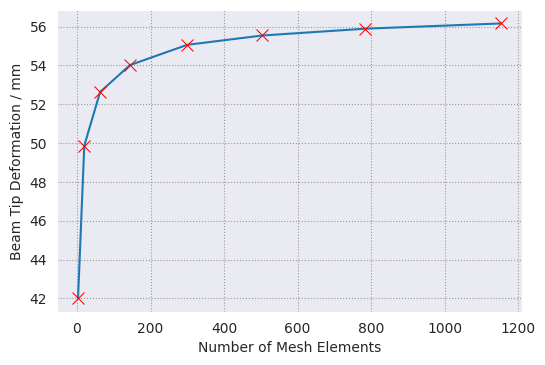

In [76]:
with open(os.path.join(data_save_dir, 'neohookean_beam_meshsize_convergence.json'), 'r') as f:
    results = json.load(f)
# Displacement convergence:
sns.lineplot(data=results, x='num_elem', y='end_disp', marker='x', markersize=8, mec='r')
plt.xlabel('Number of Mesh Elements')
plt.ylabel('Beam Tip Deformation / mm')
plt.savefig(os.path.join(fig_save_dir, 'meshsize_convergence_disp.png'), dpi=mpl_save_dpi)
plt.show()

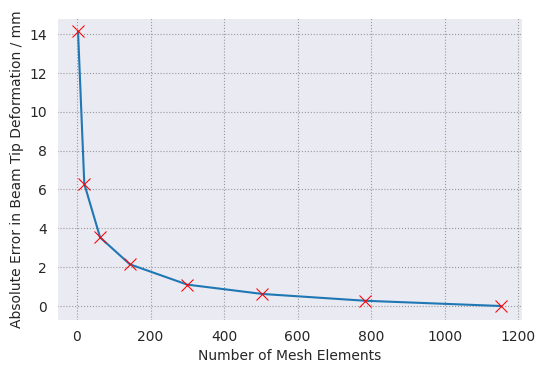

In [77]:
# Absolute error:
max_disp = np.max(results['end_disp'])
abs_error = np.abs(results['end_disp'] - max_disp)
sns.lineplot(x=results['num_elem'], y=abs_error, marker='x', markersize=8, mec='r')
plt.xlabel('Number of Mesh Elements')
plt.ylabel('Absolute Error in Beam Tip Deformation / mm')
plt.savefig(os.path.join(fig_save_dir, 'meshsize_convergence_abs_err.png'), dpi=mpl_save_dpi)
plt.show()

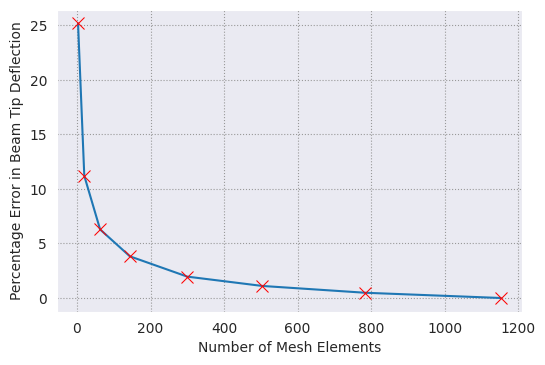

In [78]:
# Relative error:
pct_error = 100*abs_error/max_disp
sns.lineplot(x=results['num_elem'], y=pct_error, marker='x', markersize=8, mec='r')
plt.xlabel('Number of Mesh Elements')
plt.ylabel('Percentage Error in Beam Tip Deflection')
plt.savefig(os.path.join(fig_save_dir, 'meshsize_convergence_pct_err.png'), dpi=mpl_save_dpi)
plt.show()

It appears that around 500 elements (i.e. number of elements along beam width = 6) achieves an percentage error of roughly 1% - this is more than sufficient for our purposes.

## Kappa Convergence

In [80]:
fixed_params = {'C_1': 1.9, # in kPa
                'NW': 6, 
                'beam_angle': 90, # in degrees
                **always_fixed_params}
fixed_params['elem_size'] =  fixed_params['width']/fixed_params['NW']
fixed_params['NL'] =  ceil(fixed_params['length']/fixed_params['elem_size'])

# Mesh doesn't vary for different kappa values - create it once at the start:
mesh = fenics_helpers.create_cuboidal_mesh(*[fixed_params[key] for key in ('length', 'width', 'NL', 'NW')]) 

# Vary kappa between simulations:
kappa_list = [0, 500, 1000, 1500, 2000, 2500, 3000, 3250, 2500] # all in kPa

results = {key: [] for key in ('end_disp', 'volume', 'kappa')}
for i, kappa in enumerate(kappa_list):

    print(f"Simulating Mesh {i+1}/{len(kappa_list)} (Kappa = {kappa})")
    results['kappa'].append(kappa)

    u = fenics_helpers.simulate_neohookean_beam(mesh, kappa=kappa, **fixed_params)
    
    results['end_disp'].append(fenics_helpers.compute_end_displacement(u, mesh, fixed_params['width'], fixed_params['length']))
    results['volume'].append(fenics_helpers.compute_pre_and_postdeformation_volume(u, mesh))

results['fixed_params'] = fixed_params

with open(os.path.join(data_save_dir, 'neohookean_beam_kappa_convergence.json'), 'w') as f:
    json.dump(results, f, indent=4)

Simulating Mesh 1/9 (Kappa = 0)
Performing load step 1/30...
Performing load step 2/30...
Performing load step 3/30...
Performing load step 4/30...
Performing load step 5/30...
Performing load step 6/30...
Performing load step 7/30...
Performing load step 8/30...
Performing load step 9/30...
Performing load step 10/30...
Performing load step 11/30...
Performing load step 12/30...
Performing load step 13/30...
Performing load step 14/30...
Performing load step 15/30...
Performing load step 16/30...
Performing load step 17/30...
Performing load step 18/30...
Performing load step 19/30...
Performing load step 20/30...
Performing load step 21/30...
Performing load step 22/30...
Performing load step 23/30...
Performing load step 24/30...
Performing load step 25/30...
Performing load step 26/30...
Performing load step 27/30...
Performing load step 28/30...
Performing load step 29/30...
Performing load step 30/30...
Simulating Mesh 2/9 (Kappa = 500)
Performing load step 1/30...
Performing loa

Plotting the convergence results:

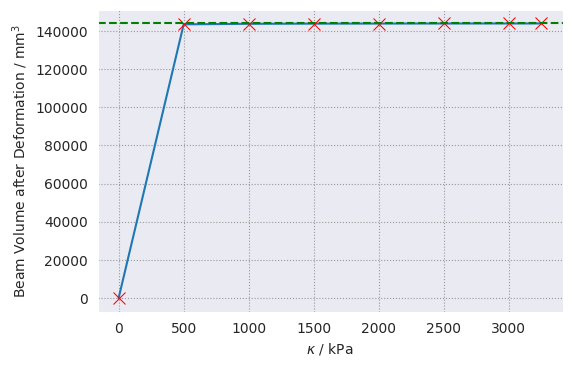

In [81]:
with open(os.path.join(data_save_dir, 'neohookean_beam_kappa_convergence.json'), 'r') as f:
    results = json.load(f)
# Volume convergence:
vols = np.array(results['volume'])
init_vol = vols[0,0]
disp_vols = vols[:,1]
sns.lineplot(x=results['kappa'], y=disp_vols, marker='x', markersize=8, mec='r')
plt.axhline(y=init_vol, color='green', linestyle='--')
plt.xlabel('$\kappa$ / kPa')
plt.ylabel('Beam Volume after Deformation / mm$^3$')
plt.savefig(os.path.join(fig_save_dir, 'kappa_convergence_vol.png'), dpi=mpl_save_dpi)
plt.show()

Let's 'zoom in' on this plot:

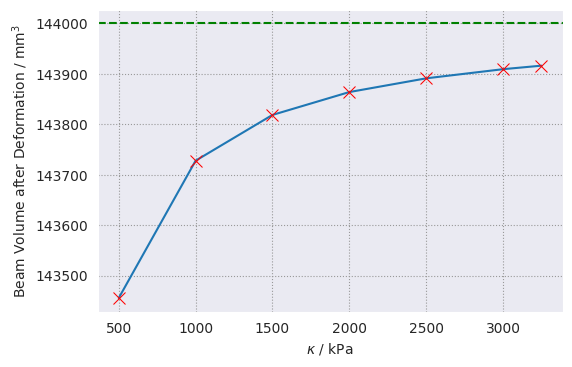

In [82]:
sns.lineplot(x=results['kappa'][1:], y=disp_vols[1:], marker='x', markersize=8, mec='r')
plt.axhline(y=init_vol, color='green', linestyle='--')
plt.xlabel('$\kappa$ / kPa')
plt.ylabel('Beam Volume after Deformation / mm$^3$')
plt.savefig(os.path.join(fig_save_dir, 'kappa_convergence_vol.png'), dpi=mpl_save_dpi)
plt.show()

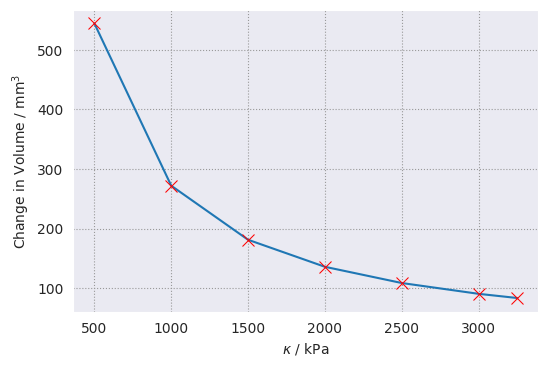

In [83]:
# Absolute error convergence:
abs_error = np.abs(disp_vols[1:] - init_vol)
sns.lineplot(x=results['kappa'][1:], y=abs_error, marker='x', markersize=8, mec='r')
plt.xlabel('$\kappa$ / kPa')
plt.ylabel('Change in Volume / mm$^3$')
plt.savefig(os.path.join(fig_save_dir, 'kappa_convergence_abs.png'), dpi=mpl_save_dpi)
plt.show()

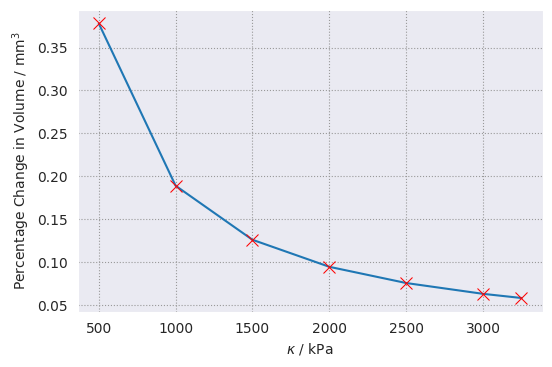

In [84]:
# Percentage error convergence:
pct_error = 100*abs_error/init_vol
sns.lineplot(x=results['kappa'][1:], y=pct_error, marker='x', markersize=8, mec='r')
plt.xlabel('$\kappa$ / kPa')
plt.ylabel('Percentage Change in Volume / mm$^3$')
plt.savefig(os.path.join(fig_save_dir, 'kappa_convergence_pct.png'), dpi=mpl_save_dpi)
plt.show()

Out of interest, let's also see to what extent $\kappa$ affects the measured beam tip displacement:

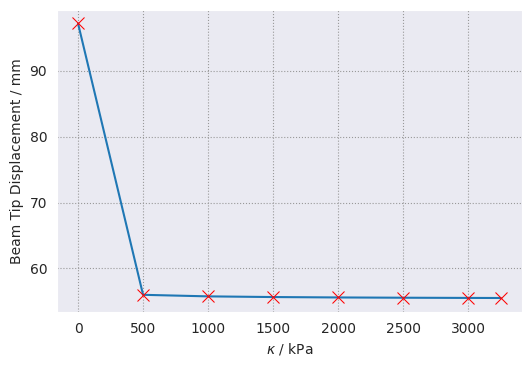

In [85]:
sns.lineplot(data=results, x='kappa', y='end_disp', marker='x', markersize=8, mec='r')
plt.xlabel('$\kappa$ / kPa')
plt.ylabel('Beam Tip Displacement / mm')
plt.savefig(os.path.join(fig_save_dir, 'kappa_convergence_disp.png'), dpi=mpl_save_dpi)
plt.show()

'Zooming in':

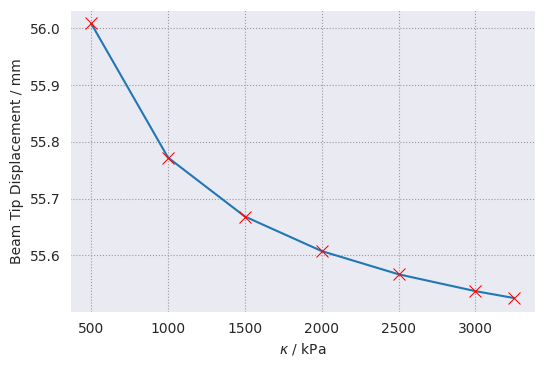

In [86]:
sns.lineplot(x=results['kappa'][1:], y=results['end_disp'][1:], marker='x', markersize=8, mec='r')
plt.xlabel('$\kappa$ / kPa')
plt.ylabel('Beam Tip Displacement / mm')
plt.savefig(os.path.join(fig_save_dir, 'kappa_convergence_disp.png'), dpi=mpl_save_dpi)
plt.show()

It appears that $\kappa$ doesn't have a particular large effect on the measured beam tip displacement. Conseqeuently, we'll stick with our initial choice of $\kappa$ = 3000 kPa. Note that for $\kappa >$ 3500 kPa, the non-linear solver tends to run into convergence issues.

# Data Generation

Define fixed params and create mesh:

In [88]:
fixed_params = {'kappa': 3000, # in kPa
                'NW': 6,
                **always_fixed_params}
fixed_params['elem_size'] =  fixed_params['width']/fixed_params['NW']
fixed_params['NL'] =  ceil(fixed_params['length']/fixed_params['elem_size'])
mesh = fenics_helpers.create_cuboidal_mesh(*[fixed_params[key] for key in ('length', 'width', 'NL', 'NW')])

Define grid points for training data evaluations:

In [94]:
num_train_pts = 10 # number of training points per dimension of grid
min_C_1, max_C_1 = 1.9, 6.9 # in kPa
C_1_list = [C_1 for C_1 in np.linspace(min_C_1, max_C_1, num_train_pts)]
min_angle, max_angle = 0, 180 # in degrees
beam_angle_list = [y for y in np.linspace(min_angle, max_angle, num_train_pts)]
training_param_combos = fenics_helpers.create_param_combos(C_1=C_1_list, beam_angle=beam_angle_list)

Define grid points for test data evaluations:

In [95]:
num_test_pts = num_train_pts-1
delta_C_1 = (max_C_1-min_C_1)/num_test_pts
delta_angle = (max_angle-min_angle)/num_test_pts
C_1_list = [C_1 for C_1 in np.linspace(min_C_1+0.5*delta_C_1, max_C_1-0.5*delta_C_1, num_test_pts)]
beam_angle_list = [angle for angle in np.linspace(min_angle+0.5*delta_angle, max_angle-0.5*delta_angle, num_test_pts)]
test_param_combos = fenics_helpers.create_param_combos(C_1=C_1_list, beam_angle=beam_angle_list)

Compute training data:

In [91]:
results = {key: [] for key in ('C_1', 'beam_angle', 'end_disp', 't_solve', 'volume')}
for i, params in enumerate(training_param_combos):
    
    print(f"Simulation {i+1}/{len(training_param_combos)} (C_1 = {params['C_1']}, Beam angle = {params['beam_angle']})")
    results['C_1'].append(params['C_1'])
    results['beam_angle'].append(params['beam_angle'])

    # Note how long each simulation takes:
    t_start = time.time()
    u = fenics_helpers.simulate_neohookean_beam(mesh, C_1=params['C_1'], beam_angle=params['beam_angle'], **fixed_params)
    t_solve = time.time() - t_start
    results['t_solve'].append(t_solve)
    print(f'Simulation took {t_solve/60:.2f} mins.\n')
    
    results['end_disp'].append(fenics_helpers.compute_end_displacement(u, mesh, fixed_params['width'], fixed_params['length']))
    results['volume'].append(fenics_helpers.compute_pre_and_postdeformation_volume(u, mesh))

results['fixed_params'] = fixed_params

with open(os.path.join(data_save_dir, 'neohookean_beam_training_data.json'), 'w') as f:
    json.dump(results, f, indent=4)

Simulation 1/100 (C_1 = 1.9, Beam angle = 0.0)
Performing load step 1/30...
Performing load step 2/30...
Performing load step 3/30...
Performing load step 4/30...
Performing load step 5/30...
Performing load step 6/30...
Performing load step 7/30...
Performing load step 8/30...
Performing load step 9/30...
Performing load step 10/30...
Performing load step 11/30...
Performing load step 12/30...
Performing load step 13/30...
Performing load step 14/30...
Performing load step 15/30...
Performing load step 16/30...
Performing load step 17/30...
Performing load step 18/30...
Performing load step 19/30...
Performing load step 20/30...
Performing load step 21/30...
Performing load step 22/30...
Performing load step 23/30...
Performing load step 24/30...
Performing load step 25/30...
Performing load step 26/30...
Performing load step 27/30...
Performing load step 28/30...
Performing load step 29/30...
Performing load step 30/30...
Simulation took 1.43 mins.

Simulation 2/100 (C_1 = 1.9, Beam 

ValueError: I/O operation on closed file.

Compute test data:

In [97]:
results = {key: [] for key in ('C_1', 'beam_angle', 'end_disp', 't_solve', 'volume')}
for i, params in enumerate(test_param_combos):
    
    print(f"Simulation {i+1}/{len(test_param_combos)} (C_1 = {params['C_1']}, Beam angle = {params['beam_angle']})")
    results['C_1'].append(params['C_1'])
    results['beam_angle'].append(params['beam_angle'])

    # Note how long each simulation takes:
    t_start = time.time()
    u = fenics_helpers.simulate_neohookean_beam(mesh, C_1=params['C_1'], beam_angle=params['beam_angle'], **fixed_params)
    t_solve = time.time() - t_start
    results['t_solve'].append(t_solve)
    print(f'Simulation took {t_solve/60:.2f} mins.\n')
    
    results['end_disp'].append(fenics_helpers.compute_end_displacement(u, mesh, fixed_params['width'], fixed_params['length']))
    results['volume'].append(fenics_helpers.compute_pre_and_postdeformation_volume(u, mesh))
    
results['fixed_params'] = fixed_params

with open(os.path.join(data_save_dir, 'neohookean_beam_test_data.json'), 'w') as f:
    json.dump(results, f, indent=4)

Simulation 1/81 (C_1 = 2.1777777777777776, Beam angle = 10.0)
Performing load step 1/30...
Performing load step 2/30...
Performing load step 3/30...
Performing load step 4/30...
Performing load step 5/30...
Performing load step 6/30...
Performing load step 7/30...
Performing load step 8/30...
Performing load step 9/30...
Performing load step 10/30...
Performing load step 11/30...
Performing load step 12/30...
Performing load step 13/30...
Performing load step 14/30...
Performing load step 15/30...
Performing load step 16/30...
Performing load step 17/30...
Performing load step 18/30...
Performing load step 19/30...
Performing load step 20/30...
Performing load step 21/30...
Performing load step 22/30...
Performing load step 23/30...
Performing load step 24/30...
Performing load step 25/30...
Performing load step 26/30...
Performing load step 27/30...
Performing load step 28/30...
Performing load step 29/30...
Performing load step 30/30...
Simulation took 1.57 mins.

Simulation 2/81 (C_